# Análisis de Datos con Spark SQL

**Objetivo del Notebook:** Aprender a utilizar la interfaz de Spark SQL para cargar datos, registrarlos como tablas temporales y ejecutar consultas SQL estándar para realizar análisis de datos distribuidos.

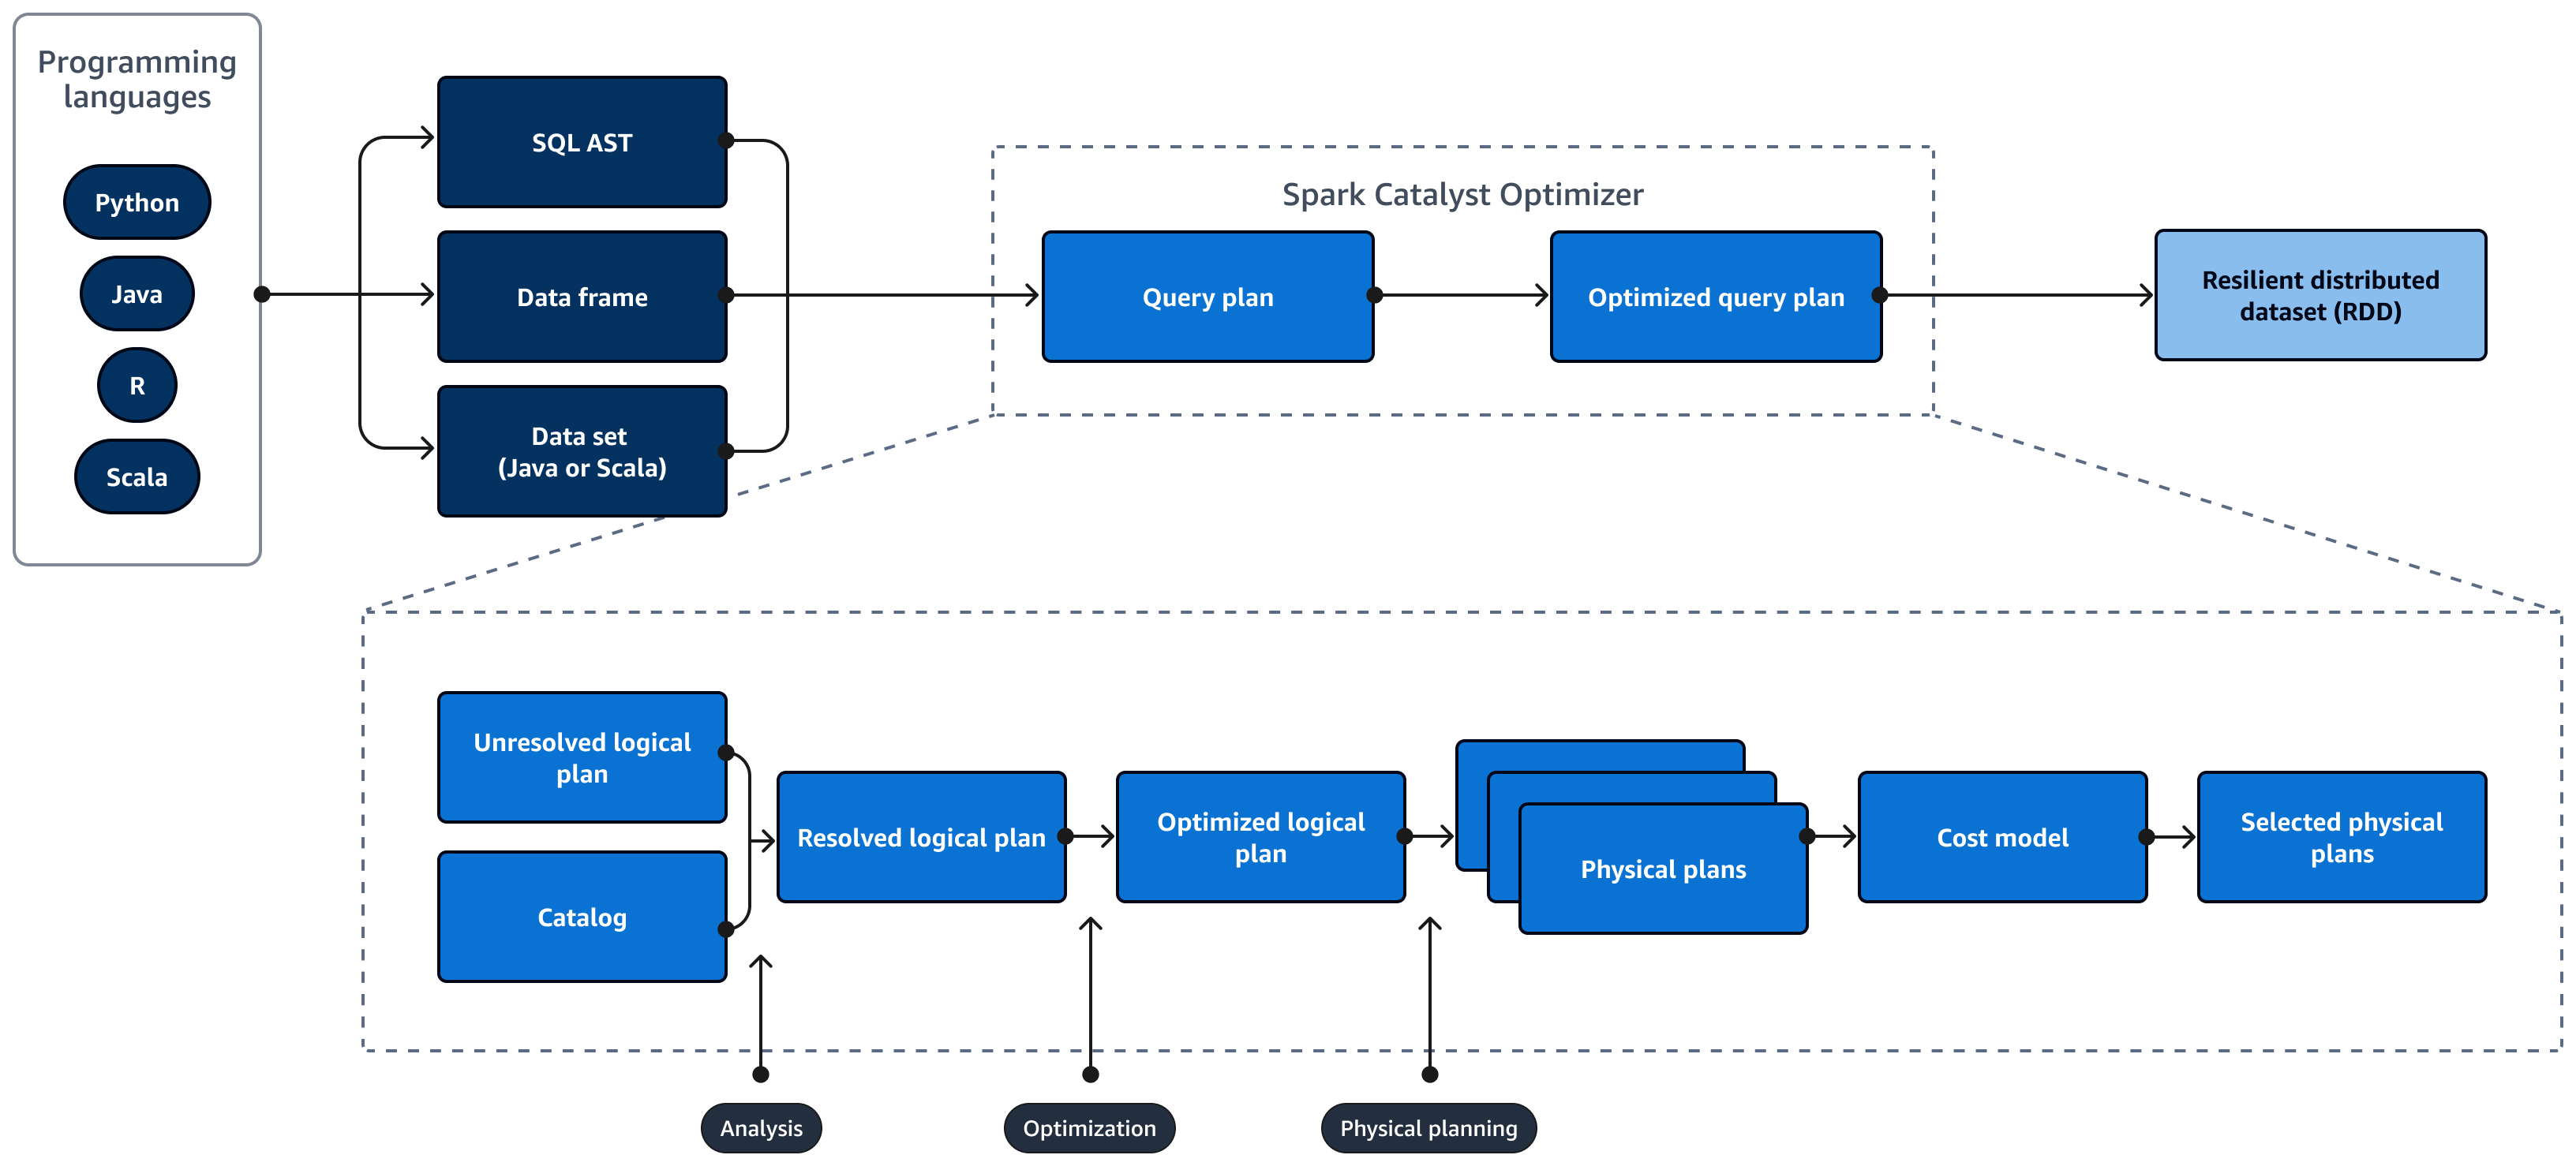

Spark SQL es un módulo de Spark para el procesamiento de datos estructurados. La gran ventaja es que permite a los analistas y desarrolladores con experiencia en SQL aprovechar el poder del motor de computación distribuida de Spark sin necesidad de aprender una API compleja.

**Aprenderemos a:**
1.  **Iniciar una `SparkSession`**, el punto de entrada para Spark SQL.
2.  **Cargar un conjunto de datos** (un archivo CSV) en un DataFrame de Spark.
3.  **Crear una "vista temporal"**, que nos permite tratar un DataFrame como si fuera una tabla de SQL.
4.  **Ejecutar consultas SQL** (`SELECT`, `WHERE`, `GROUP BY`, `AVG`, etc.) sobre nuestros datos.
5.  **Combinar el poder de Spark SQL y la API de DataFrames**.

## 1. Configuración del Entorno

Primero, necesitamos instalar `pyspark` e iniciar nuestra `SparkSession`. La `SparkSession` es el punto de entrada unificado para trabajar con los datos estructurados en Spark.

In [1]:
# =================================================================
# Paso 1: Instalar PySpark e iniciar la SparkSession
# =================================================================
!pip install pyspark -q

from pyspark.sql import SparkSession

# Crear la SparkSession
spark = SparkSession.builder \
    .appName("TutorialSparkSQL") \
    .getOrCreate()

print("✅ SparkSession iniciada correctamente.")

✅ SparkSession iniciada correctamente.


## 2. Cargar los Datos

Para poder hacer consultas, primero necesitamos datos. Vamos a utilizar el clásico dataset del **Titanic**. Lo descargaremos y lo cargaremos en un **DataFrame** de Spark. Un DataFrame es la estructura de datos principal en Spark, similar a una tabla en una base de datos relacional.

In [2]:
# =================================================================
# Paso 2: Descargar y cargar el dataset del Titanic en un DataFrame
# =================================================================
# Descargamos el archivo CSV
!wget -q https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv -O titanic.csv

# Cargamos el CSV en un DataFrame
# - header=True: Usa la primera fila como encabezado (nombres de columna).
# - inferSchema=True: Spark intentará adivinar el tipo de dato de cada columna (ej. Integer, String, Double).
df_titanic = spark.read.csv(
    "titanic.csv",
    header=True,
    inferSchema=True
)

# Mostremos la estructura (esquema) y algunos datos para verificar
print("📝 Esquema del DataFrame:")
df_titanic.printSchema()

print("\n🚢 Primeras filas del dataset del Titanic:")
df_titanic.show(5)

📝 Esquema del DataFrame:
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)


🚢 Primeras filas del dataset del Titanic:
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|        

## 3. Crear una Vista Temporal SQL

Para poder usar SQL sobre nuestro DataFrame, necesitamos "registrarlo" como una tabla. Esto se hace creando una **vista temporal**. Una vista temporal existe únicamente durante la sesión de Spark y nos permite referenciar el DataFrame por un nombre de tabla en nuestras consultas SQL.

Usaremos el comando `createOrReplaceTempView()`.

In [3]:
# =================================================================
# Paso 3: Registrar el DataFrame como una vista temporal
# =================================================================
df_titanic.createOrReplaceTempView("titanic_table")

print("✅ Vista temporal 'titanic_table' creada. ¡Ya podemos usar SQL!")

✅ Vista temporal 'titanic_table' creada. ¡Ya podemos usar SQL!


## 4. Ejecutando Consultas con Spark SQL

¡Ha llegado el momento de usar SQL! Usaremos el método `spark.sql()` para pasarle cualquier consulta SQL válida como un string. El resultado de cada consulta será un nuevo DataFrame.

Vamos a realizar varias consultas, aumentando la complejidad.

In [4]:
# =================================================================
# Consulta 1: Selección simple con filtro
# Objetivo: Seleccionar el nombre, la edad y la clase de los pasajeros que sobrevivieron.
# =================================================================
sobrevivientes = spark.sql("""
    SELECT Name, Age, Pclass
    FROM titanic_table
    WHERE Survived = 1
    LIMIT 10
""")

print("👩‍ survivor 👨‍- Primeros 10 sobrevivientes:")
sobrevivientes.show()

👩‍ survivor 👨‍- Primeros 10 sobrevivientes:
+--------------------+----+------+
|                Name| Age|Pclass|
+--------------------+----+------+
|Cumings, Mrs. Joh...|38.0|     1|
|Heikkinen, Miss. ...|26.0|     3|
|Futrelle, Mrs. Ja...|35.0|     1|
|Johnson, Mrs. Osc...|27.0|     3|
|Nasser, Mrs. Nich...|14.0|     2|
|Sandstrom, Miss. ...| 4.0|     3|
|Bonnell, Miss. El...|58.0|     1|
|Hewlett, Mrs. (Ma...|55.0|     2|
|Williams, Mr. Cha...|NULL|     2|
|Masselmani, Mrs. ...|NULL|     3|
+--------------------+----+------+



In [ ]:
# =================================================================
# Consulta 2: Agregación con GROUP BY
# Objetivo: Contar cuántas personas sobrevivieron y cuántas no.
# =================================================================
conteo_supervivencia = spark.sql("""
    SELECT
        CASE
            WHEN Survived = 1 THEN 'Sobrevivió'
            ELSE 'No Sobrevivió'
        END as estado,
        COUNT(*) as total
    FROM titanic_table
    GROUP BY Survived
""")

print("📊 Conteo de supervivencia:")
conteo_supervivencia.show()

📊 Conteo de supervivencia:
+-------------+-----+
|       estado|total|
+-------------+-----+
|   Sobrevivió|  342|
|No Sobrevivió|  549|
+-------------+-----+



In [ ]:
# =================================================================
# Consulta 3: Agregaciones múltiples y ordenamiento
# Objetivo: Calcular la edad promedio y la tarifa máxima pagada por clase de pasajero.
# =================================================================
analisis_por_clase = spark.sql("""
    SELECT
        Pclass as clase,
        ROUND(AVG(Age), 2) as edad_promedio,
        MAX(Fare) as tarifa_maxima
    FROM titanic_table
    GROUP BY Pclass
    ORDER BY Pclass ASC
""")

print("💰 Análisis por clase de pasajero:")
analisis_por_clase.show()

💰 Análisis por clase de pasajero:
+-----+-------------+-------------+
|clase|edad_promedio|tarifa_maxima|
+-----+-------------+-------------+
|    1|        38.23|     512.3292|
|    2|        29.88|         73.5|
|    3|        25.14|        69.55|
+-----+-------------+-------------+



## 5. Combinando SQL y la API de DataFrames

Una de las características más potentes de Spark es que puedes mezclar y combinar la API de SQL con la API de DataFrames de forma fluida. El resultado de `spark.sql()` es siempre un DataFrame, sobre el cual puedes aplicar más transformaciones.

In [ ]:
# =================================================================
# El resultado de la consulta anterior es un DataFrame
# =================================================================
print("El resultado de la consulta SQL es un DataFrame. Aquí está su esquema:")
analisis_por_clase.printSchema()

# Ahora, podemos usar la API de DataFrames para filtrar este resultado.
# Por ejemplo, mostremos solo las clases cuya tarifa máxima fue superior a 250.
print("\nFiltrando el resultado con la API de DataFrames:")
analisis_por_clase.filter(analisis_por_clase.tarifa_maxima > 250).show()

# Detenemos la sesión de Spark para liberar recursos
spark.stop()

El resultado de la consulta SQL es un DataFrame. Aquí está su esquema:
root
 |-- clase: integer (nullable = true)
 |-- edad_promedio: double (nullable = true)
 |-- tarifa_maxima: double (nullable = true)


Filtrando el resultado con la API de DataFrames:
+-----+-------------+-------------+
|clase|edad_promedio|tarifa_maxima|
+-----+-------------+-------------+
|    1|        38.23|     512.3292|
+-----+-------------+-------------+

